<a href="https://colab.research.google.com/github/jjocham/DeepLearners/blob/main/flipped_classroom_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Prep
import tensorflow as tf
import tensorflow_datasets as tfds
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train','test'], as_supervised=True, with_info=True)

def prepare_mnist_data(mnist):
  """
    data preprocessing pipeline,
    converts data points into float32, reshapes the images, normalizes the values on a range from [-1,1],
    translates targets into one-hot targets,
    caches the progress and shuffles before it batches the data and prefetches the batches
    input: TensorFlow dataset to preprocess
    returns: preprocessed dataset

  """
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [ ]:
# Model Creation via Subclassing from tf.keras.Model
class MLP_Model(tf.keras.Model):
    """
      creates a MLP_Model object that inherets its properties from its parent class tf.keras.Model
      It instantiates the specified # Dense layers with the specified # of units and activation function.
      Allows different # units and activation function in output layer
      returns: predictions of last layer in the ANN
    """
    def __init__(self, layer_sizes, output_size=10):
      super(MLP_Model, self).__init__()
      self.mlp_layers = []
      # layer_sizes e.g. [256, 256]
      for layer_size in layer_sizes:
        new_layer = tf.keras.layers.Dense(units=layer_size, activation='sigmoid')
        self.layers.append(new_layer)
      self.output_layer = tf.keras.layers.Dense(units=output_size, activation='softmax')

    @tf.function
    def call(self, x):
      for layer in self.mlp_layers:
        x = layer(x)
      y = self.output_layer(x)
      return y

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  """
    performs training step on the model and updates loss and accuracy metrics
    Args:
          model - MLP_Model object
          input - batch of flattened images
          target - batch of one-hot target predicitons
          loss_function - type of loss function
          optimizer - type of optimizer
    returns:
          loss - updated loss for current subset
          accuracy - updated accuracy for current subset
  """
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

# Probably shouldnt be called "test_data" as arg, because can also be used on training data
# alternatively something like "data" & "loss" & "accuracy" would probably be better
def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
def full_training_loop(num_epochs, model, ds_train, ds_test, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):
    # We train for num_epochs epochs.
    for epoch in range(num_epochs):
        print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

        #training (and checking in with training)
        epoch_loss_agg = []
        for input,target in ds_train:
            train_loss = train_step(model, input, target, loss_function, optimizer)
            epoch_loss_agg.append(train_loss)

        #track training loss
        train_loss, train_accuracy = test(model, train_dataset, cce_loss)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


        #testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, ds_test, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return train_losses, test_losses, test_accuracies, train_accuracies

In [ ]:
class hyperparameter_tracking():
    def __init__(epochs, lr, layer_sizes, momentum=None):
        self.
def epochal_routine(epochs, lr, layer_sizes):
    ### Hyperparameters
    EPOCHS = epochs
    learning_rate = lr
    images_dir = '/usr/lib/file'



    # Initialize the model.
    model = MLP_Model(layer_sizes)
    # Initialize the loss: categorical cross entropy.
    cce_loss = tf.keras.losses.CategoricalCrossentropy()
    # Initialize the optimizer: SGD with default parameters.
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    # Data
    train_dataset = train_dataset
    test_dataset = test_dataset

    # Initialize lists for later visualization.
    train_accuracies = []
    train_losses = []
    test_losses = []
    test_accuracies = []

    #testing once before we begin
    test_loss, test_accuracy = test(model, test_dataset, cce_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    #check how model performs on train data once before we begin
    train_loss, train_accuracies = test(model, train_dataset, cce_loss)
    train_losses.append(train_loss)

    train_losses, test_losses, test_accuracies = full_training_loop(EPOCHS, model, train_dataset, test_dataset, cce_loss, optimizer, train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
import numpy as np
tf.keras.backend.clear_session()

### Hyperparameters
EPOCHS = 10
learning_rate = 0.01
layer_size = [256, 256]
# images_dir = '/usr/lib/file'



# Initialize the model.
model = MLP_Model(layer_size)
# Initialize the loss: categorical cross entropy.
cce_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate)
# Data
train_dataset = train_dataset
test_dataset = test_dataset

# Initialize lists for later visualization.
train_accuracies = []
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cce_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_dataset, cce_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)


train_losses, test_losses, test_accuracies, train_accuracies = full_training_loop(EPOCHS, model, train_dataset, test_dataset, cce_loss, optimizer, train_losses, train_accuracies, test_losses, test_accuracies)


Epoch: 0 starting with accuracy 0.150758785942492
Epoch: 1 starting with accuracy 0.9014576677316294
Epoch: 2 starting with accuracy 0.9087460063897763
Epoch: 3 starting with accuracy 0.9144369009584664
Epoch: 4 starting with accuracy 0.9169329073482428
Epoch: 5 starting with accuracy 0.9175319488817891
Epoch: 6 starting with accuracy 0.9206269968051118
Epoch: 7 starting with accuracy 0.9187300319488818
Epoch: 8 starting with accuracy 0.919129392971246
Epoch: 9 starting with accuracy 0.9168330670926518


In [ ]:
# VISUALIZATION
import matplotlib.pyplot as plt

def viz_save(train_losses, test_losses, test_accuracies, train_accuracies):
    # Visualize accuracy and loss for training and test data.
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    line3, = plt.plot(test_accuracies)
    line4, = plt.plot(train_accuracies)
    tf.print("train accuracies",train_accuracies)
    tf.print("test accuracies",test_accuracies)
    tf.print("train loss", train_losses)
    tf.print("test loss", test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1,line2, line3, line4),("training","test", "test accuracy", "train_accuracy"))
    plt.show()
    # plt.savefig(f"{self.images_dir}/{self.epochs}, {self.learning_rate}, {self.layer_sizes}.png")

train accuracies [0.14408333333333334, 0.89636666666666664, 0.90346666666666664, 0.91036666666666666, 0.91383333333333339, 0.91538333333333333, 0.91751666666666665, 0.91883333333333328, 0.9192, 0.91773333333333329, 0.91731666666666667]
test accuracies [0.150758785942492, 0.90145766773162939, 0.90874600638977632, 0.91443690095846641, 0.91693290734824284, 0.91753194888178913, 0.92062699680511184, 0.91873003194888181, 0.919129392971246, 0.91683306709265178, 0.91743210862619806]
train loss [2.51470661, 0.369074315, 0.335282326, 0.314099193, 0.30502519, 0.297255218, 0.291961133, 0.286987096, 0.285028696, 0.287307352, 0.285215229]
test loss [2.49731731, 0.353594631, 0.321084201, 0.306561202, 0.300682932, 0.293196023, 0.290219218, 0.286300749, 0.285530627, 0.289703399, 0.286253631]


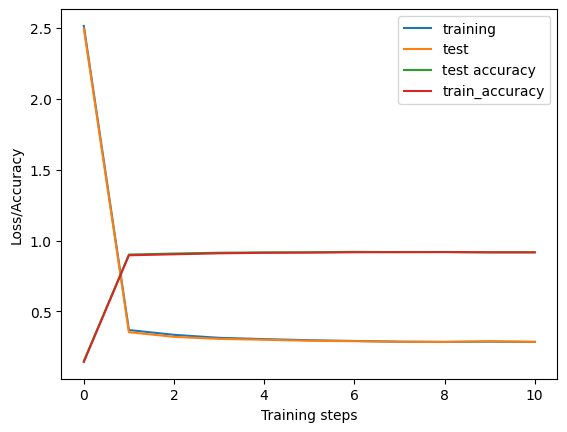

In [ ]:
viz_save(train_losses, test_losses, test_accuracies, train_accuracies)